In [50]:
import pandas as pd
import numpy as np
import pickle
import warnings
import matplotlib.pyplot as plt
from pandas import DataFrame
warnings.filterwarnings('ignore')

## Chicago models

For this part in our analysis of the crime in Chicago, we will try to find patterns in the chicago crime dataset by modeling it for different purposes using a variety of machine learning methods. The idea is to build two kind of models : 
1. **Arrest prediction model** : This model will try to , given the various information of a crime that are available to our crime dataset and which might correspond to the amount of information the autority would have about a recent unsolved crime, return the probability of the culprit of the crime beeing arrested.

2. **Crime type predicton model** : The goal of this model would be to give the probability of the type of crimes given again the data of the crime dataset except the Description (obviously it is highly correllated to the type of crime) and the Arrest (usually if we want to know the type of crime, the culprit isn't arrested). This model could be useful in several ways, for example the police might find it useful for knowing what to expect of a potential crime in a given location.

### Data Loading

We use the near fully cleaned chicago crime dataset that we use in milestone 2

In [2]:
chicago_crime = pickle.load(open('./data/chicago_crime.pickle', 'rb'))

In [3]:
chicago_crime_init = chicago_crime.copy()

In [4]:
chicago_crime.head()

,Date,Primary Type,Description,Location Description,Arrest,Domestic,Community Area,Year,Latitude,Longitude,Hour,Day,Month
60345,2019-01-03 19:00:00,PUBLIC PEACE VIOLATION,OTHER VIOLATION,AIRCRAFT,False,False,76,2019,42.002816,-87.906094,19,3,1
62272,2019-03-16 18:00:00,BATTERY,SIMPLE,STREET,False,False,32,2019,41.883369,-87.633860,18,16,3
62615,2019-03-12 22:00:00,THEFT,$500 AND UNDER,RESIDENTIAL YARD (FRONT/BACK),False,False,36,2019,41.825347,-87.606781,22,12,3
62648,2019-03-14 19:00:00,BATTERY,SIMPLE,RESIDENCE,False,False,1,2019,42.016542,-87.672499,19,14,3
62649,2019-03-14 16:00:00,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,True,36,2019,41.825299,-87.606961,16,14,3


In [5]:
chicago_crime.shape

(6944360, 13)

### Feature cleaning and engineering

We will need to do some cleaning and see if we need some potential feature engineering that could help our models

Let's first see if we still have missing data

In [7]:
chicago_crime.isnull().mean()

Date                    0.000000
Primary Type            0.000000
Description             0.000000
Location Description    0.000000
Arrest                  0.000000
Domestic                0.000000
Community Area          0.087011
Year                    0.000000
Latitude                0.000000
Longitude               0.000000
Hour                    0.000000
Day                     0.000000
Month                   0.000000
dtype: float64

Only the community area has some missing values, as it is only a small portion of the dataset we will simply disregard the rows with missing value

In [8]:
chicago_crime = chicago_crime[chicago_crime.notna().all(1)]

In [9]:
chicago_crime.isnull().sum()

Date                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Community Area          0
Year                    0
Latitude                0
Longitude               0
Hour                    0
Day                     0
Month                   0
dtype: int64

- **Date**

The information about the date and time is already in other columns so we can remove the Date column

In [10]:
chicago_crime.drop(columns='Date', inplace=True)

- **Primary Type**

In [11]:
p_type = chicago_crime['Primary Type']

In [12]:
p_type.nunique()

34

In [13]:
p_type_vc = p_type.value_counts()
p_type_vc

THEFT                                1344440
BATTERY                              1159460
CRIMINAL DAMAGE                       724093
NARCOTICS                             649432
ASSAULT                               398093
OTHER OFFENSE                         393281
BURGLARY                              364091
MOTOR VEHICLE THEFT                   288011
DECEPTIVE PRACTICE                    253592
ROBBERY                               239517
CRIMINAL TRESPASS                     182296
WEAPONS VIOLATION                      71076
PROSTITUTION                           60505
PUBLIC PEACE VIOLATION                 45788
OFFENSE INVOLVING CHILDREN             42838
CRIM SEXUAL ASSAULT                    25313
SEX OFFENSE                            22626
INTERFERENCE WITH PUBLIC OFFICER       16103
GAMBLING                               13351
LIQUOR LAW VIOLATION                   12186
ARSON                                  10149
HOMICIDE                                9595
KIDNAPPING

So we have 34 different type of crimes which as we can see are not equally distributed

We can first regroup some types that are similar

In [14]:
similar_types = {'NARCOTICS' : ['NARCOTICS', 'OTHER NARCOTIC VIOLATION'], 'SEXUAL CRIME' : ['SEX OFFENSE', 'CRIM SEXUAL ASSAULT', 'PROSTITUTION'], 'PUBLIC PEACE VIOLATION' : ['OBSCENITY', 'PUBLIC INDECENCY']}
type_to_group ={e : v for v in similar_types for e in similar_types[v]}

In [15]:
chicago_crime['Primary Type'].replace(type_to_group, inplace=True)

In [16]:
p_type_vc = p_type.value_counts()
p_type_vc

THEFT                                1344440
BATTERY                              1159460
CRIMINAL DAMAGE                       724093
NARCOTICS                             649550
ASSAULT                               398093
OTHER OFFENSE                         393281
BURGLARY                              364091
MOTOR VEHICLE THEFT                   288011
DECEPTIVE PRACTICE                    253592
ROBBERY                               239517
CRIMINAL TRESPASS                     182296
SEXUAL CRIME                          108444
WEAPONS VIOLATION                      71076
PUBLIC PEACE VIOLATION                 46535
OFFENSE INVOLVING CHILDREN             42838
INTERFERENCE WITH PUBLIC OFFICER       16103
GAMBLING                               13351
LIQUOR LAW VIOLATION                   12186
ARSON                                  10149
HOMICIDE                                9595
KIDNAPPING                              5628
INTIMIDATION                            3718
STALKING  

Some types have too low frequency to be of use in our future models. To address thid issue, we simply regroup the low frequency types in the type : 'OTHER OFFENSE'

In [17]:
def regroup_low_fred(data, column, min_freq, name='OTHER') :
    freq = data[column].value_counts()
    lowf_types = list(freq[freq <min_freq].index)
    data[column] = data[column].apply(lambda x : name if x in lowf_types else x)

In [18]:
regroup_low_fred(chicago_crime, 'Primary Type', 9500, 'OTHER OFFENSE')

In [19]:
chicago_crime['Primary Type'].value_counts()

THEFT                               1344440
BATTERY                             1159460
CRIMINAL DAMAGE                      724093
NARCOTICS                            649550
OTHER OFFENSE                        406703
ASSAULT                              398093
BURGLARY                             364091
MOTOR VEHICLE THEFT                  288011
DECEPTIVE PRACTICE                   253592
ROBBERY                              239517
CRIMINAL TRESPASS                    182296
SEXUAL CRIME                         108444
WEAPONS VIOLATION                     71076
PUBLIC PEACE VIOLATION                46535
OFFENSE INVOLVING CHILDREN            42838
INTERFERENCE WITH PUBLIC OFFICER      16103
GAMBLING                              13351
LIQUOR LAW VIOLATION                  12186
ARSON                                 10149
HOMICIDE                               9595
Name: Primary Type, dtype: int64

- **Description**

In [20]:
chicago_crime['Description'].nunique()

378

In [21]:
chicago_crime['Description'].value_counts()

SIMPLE                                          697667
DOMESTIC BATTERY SIMPLE                         539453
$500 AND UNDER                                  490446
TO VEHICLE                                      350456
TO PROPERTY                                     330926
OVER $500                                       319577
POSS: CANNABIS 30GMS OR LESS                    256654
FORCIBLE ENTRY                                  244762
FROM BUILDING                                   235493
AUTOMOBILE                                      227583
RETAIL THEFT                                    177448
TELEPHONE THREAT                                124703
TO LAND                                         111883
POSS: CRACK                                     101271
UNLAWFUL ENTRY                                   98411
HARASSMENT BY TELEPHONE                          90845
ARMED: HANDGUN                                   85009
POSS: HEROIN(WHITE)                              83877
STRONGARM 

Again we have quite a lot of descriptions. We will regroup the low frequencies again

In [22]:
regroup_low_fred(chicago_crime, 'Description', 10000)

In [23]:
chicago_crime['Description'].nunique()

70

In [24]:
chicago_crime['Description'].value_counts()

SIMPLE                                             697667
DOMESTIC BATTERY SIMPLE                            539453
$500 AND UNDER                                     490446
OTHER                                              422039
TO VEHICLE                                         350456
TO PROPERTY                                        330926
OVER $500                                          319577
POSS: CANNABIS 30GMS OR LESS                       256654
FORCIBLE ENTRY                                     244762
FROM BUILDING                                      235493
AUTOMOBILE                                         227583
RETAIL THEFT                                       177448
TELEPHONE THREAT                                   124703
TO LAND                                            111883
POSS: CRACK                                        101271
UNLAWFUL ENTRY                                      98411
HARASSMENT BY TELEPHONE                             90845
ARMED: HANDGUN

- **Local Description**


In [25]:
chicago_crime['Location Description'].nunique()

180

In [26]:
chicago_crime['Location Description'].value_counts()

STREET                            1627757
RESIDENCE                         1051303
APARTMENT                          689487
SIDEWALK                           644724
OTHER                              236698
PARKING LOT/GARAGE(NON.RESID.)     180229
ALLEY                              141841
SCHOOL, PUBLIC, BUILDING           130375
RESIDENCE-GARAGE                   121553
SMALL RETAIL STORE                 115926
RESIDENCE PORCH/HALLWAY            110885
VEHICLE NON-COMMERCIAL             106327
RESTAURANT                         103175
DEPARTMENT STORE                    79884
GROCERY FOOD STORE                  79494
RESIDENTIAL YARD (FRONT/BACK)       73933
GAS STATION                         69614
PARK PROPERTY                       49215
CHA PARKING LOT/GROUNDS             44825
COMMERCIAL / BUSINESS OFFICE        43543
BAR OR TAVERN                       35621
CTA PLATFORM                        33151
CHA APARTMENT                       29070
DRUG STORE                        

Same as for Description

In [27]:
regroup_low_fred(chicago_crime, 'Location Description', 10000 )

In [28]:
chicago_crime['Location Description'].nunique()

44

In [29]:
chicago_crime['Location Description'].value_counts()

STREET                               1627757
RESIDENCE                            1051303
APARTMENT                             689487
SIDEWALK                              644724
OTHER                                 389773
PARKING LOT/GARAGE(NON.RESID.)        180229
ALLEY                                 141841
SCHOOL, PUBLIC, BUILDING              130375
RESIDENCE-GARAGE                      121553
SMALL RETAIL STORE                    115926
RESIDENCE PORCH/HALLWAY               110885
VEHICLE NON-COMMERCIAL                106327
RESTAURANT                            103175
DEPARTMENT STORE                       79884
GROCERY FOOD STORE                     79494
RESIDENTIAL YARD (FRONT/BACK)          73933
GAS STATION                            69614
PARK PROPERTY                          49215
CHA PARKING LOT/GROUNDS                44825
COMMERCIAL / BUSINESS OFFICE           43543
BAR OR TAVERN                          35621
CTA PLATFORM                           33151
CHA APARTM

In [30]:
#pickle.dump(chicago_crime, open('data/chicago_crimes_processing.pkl', 'wb'))

In [14]:
chicago_crime = pickle.load(open('data/chicago_crimes_processing.pkl', 'rb'))

In [32]:
chicago_crime.head()

,Primary Type,Description,Location Description,Arrest,Domestic,Community Area,Year,Latitude,Longitude,Hour,Day,Month
60345,PUBLIC PEACE VIOLATION,OTHER,OTHER,False,False,76,2019,42.002816,-87.906094,19,3,1
62272,BATTERY,SIMPLE,STREET,False,False,32,2019,41.883369,-87.633860,18,16,3
62615,THEFT,$500 AND UNDER,RESIDENTIAL YARD (FRONT/BACK),False,False,36,2019,41.825347,-87.606781,22,12,3
62648,BATTERY,SIMPLE,RESIDENCE,False,False,1,2019,42.016542,-87.672499,19,14,3
62649,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,True,36,2019,41.825299,-87.606961,16,14,3


### Data preparation

We will now prepare the data to be used in our models. For our data to be used in models we need to :
- **Numericalize** : transorm the non-numerical data in numerical data by simply assigning a number for each value of a feature
- **Normalize** : normalize the numerical data. This will help some type of models to train

In [2]:
from fastai.tabular.data import TabularProc

#### Numericalize

We will use a **myCategorify** object that categorify the non_numercal data (transform the pandas object column in a cat column) and store the mapping from the values to the number assigned so that we can reuse it on test data

In [3]:
class myCategorify(TabularProc):
    "Transform the categorical variables to that type."
    def apply_train(self, df:DataFrame):
        "Transform `self.cat_names` columns in categorical."
        self.categories = {}
        for n in self.cat_names:
            df.loc[:,n] = df.loc[:,n].astype('category').cat.as_ordered()
            self.categories[n] = df[n].cat.categories

    def apply_test(self, df:DataFrame):
        "Transform `self.cat_names` columns in categorical using the codes decided in `apply_train`."
        for n in self.cat_names:
            if n in df.columns :
                df.loc[:,n] = pd.Categorical(df[n], categories=self.categories[n], ordered=True)

In [35]:
# The non-numercal data columns
cat_vars = ['Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Community Area']
# The numercal data columns
cont_vars = ['Year', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month']

In [36]:
cat_proc = myCategorify(cat_vars, cont_vars)

In [37]:
cat_proc(chicago_crime)

Now that the columns are of type category we can transform the values in their respective number

In [38]:
for c in cat_vars :
    chicago_crime[c] = chicago_crime[c].cat.codes

#### Normalizing 

We will again use an object to store the normalizing data 

In [4]:
class my_Normalize(TabularProc):
    "Normalize the continuous variables."
    def apply_train(self, df:DataFrame):
        "Comput the means and stds of `self.cont_names` columns to normalize them."
        self.means,self.stds = {},{}
        for n in self.cont_names:
            self.means[n],self.stds[n] = df.loc[:,n].mean(),df.loc[:,n].std()
            df.loc[:,n] = (df.loc[:,n]-self.means[n]) / (1e-7 + self.stds[n])

    def apply_test(self, df:DataFrame):
        "Normalize `self.cont_names` with the same statistics as in `apply_train`."
        for n in self.cont_names:
            if n in df.columns :
                df.loc[:,n] = (df.loc[:,n]-self.means[n]) / (1e-7 + self.stds[n])


In [40]:
norm_proc = my_Normalize(cat_vars, cont_vars)

In [ ]:
norm_proc(chicago_crime)

Now that the data has been prepared, we can save our Numericalizer and Normalize object which will be of use afterwards

In [46]:
#pickle.dump((cat_proc, norm_proc), open('data_processors.pkl', 'wb'))

In [43]:
#pickle.dump((chicago_crime, cat_proc, norm_proc), open('data/chicago_crimes_processing_data.pkl', 'wb'))

In [15]:
chicago_crime, cat_proc, norm_proc = pickle.load(open('data/chicago_crimes_processing_data.pkl', 'rb'))

Here is the prepared data

In [47]:
chicago_crime.head()

,Primary Type,Description,Location Description,Arrest,Domestic,Community Area,Year,Latitude,Longitude,Hour,Day,Month
60345,15,39,26,0,0,76,1.918047,1.863753,-3.962305,0.860247,-1.432802,-1.701383
62272,2,52,40,0,0,32,1.918047,0.480551,0.640177,0.713617,0.038834,-1.095794
62615,18,0,33,0,0,36,1.918047,-0.191352,1.097996,1.300135,-0.413977,-1.095794
62648,2,52,30,0,0,1,1.918047,2.022692,-0.013068,0.860247,-0.187572,-1.095794
62649,14,40,40,0,1,36,1.918047,-0.191911,1.094947,0.420358,-0.187572,-1.095794


### Arrest prediction

So as we said before, our first model will try to predict the Arrest column for the other columns of the dataset

Let's look at the distribution of the arrests

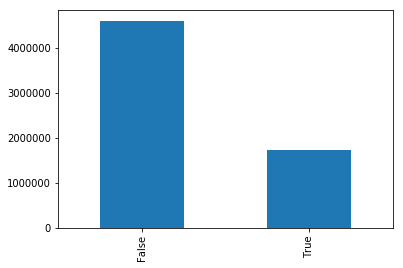

In [48]:
chicago_crime['Arrest'].map({1 : 'True', 0: 'False'}).value_counts().plot(kind='bar')
plt.show()

We can see taht the data is not very well balance, we will focus on the f1 score as the metric.

#### Splitting data

We first need to split the depend variable 'Arrest' and the other independent variables. For testing models, we should use a sample of the dataset as the full dataset is too large.

In [5]:
def get_sample(X, y,pctg=0.1) :
    permu = np.random.permutation(X.shape[0])
    idxs = permu[:int(pctg*X.shape[0])]
    return X.iloc[idxs], y.iloc[idxs]

In [50]:
indep_vars = ['Primary Type', 'Description', 'Location Description',
       'Domestic', 'Year', 'Latitude', 'Longitude', 'Hour', 'Community Area',
       'Day', 'Month']
dep_var = 'Arrest'

In [51]:
X, y = chicago_crime[indep_vars], chicago_crime[dep_var]

In [52]:
X.head()

,Primary Type,Description,Location Description,Domestic,Year,Latitude,Longitude,Hour,Community Area,Day,Month
60345,15,39,26,0,1.918047,1.863753,-3.962305,0.860247,76,-1.432802,-1.701383
62272,2,52,40,0,1.918047,0.480551,0.640177,0.713617,32,0.038834,-1.095794
62615,18,0,33,0,1.918047,-0.191352,1.097996,1.300135,36,-0.413977,-1.095794
62648,2,52,30,0,1.918047,2.022692,-0.013068,0.860247,1,-0.187572,-1.095794
62649,14,40,40,1,1.918047,-0.191911,1.094947,0.420358,36,-0.187572,-1.095794


In [53]:
X_sample, y_sample = get_sample(X, y, pctg=0.1)

We can now split the data between training and validation set so we can get an idea of how well does our model genralizes

In [6]:
from sklearn.model_selection import train_test_split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.1)

In [56]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((570610, 11), (63402, 11), (570610,), (63402,))

In [57]:
X_train.head()

,Primary Type,Description,Location Description,Domestic,Year,Latitude,Longitude,Hour,Community Area,Day,Month
2819399,2,20,30,0,-1.089723,-0.818225,0.048689,0.860247,67,0.944456,-1.095794
3373030,3,25,30,0,-0.889205,0.209192,0.807212,-0.019531,33,-1.432802,-0.187412
3763017,3,25,32,0,-0.688687,0.853615,-0.576693,-1.485826,22,0.378442,-0.793000
137098,4,62,40,0,1.918047,0.852055,-0.118983,1.006876,22,0.265239,0.418176
4826728,18,0,40,0,-0.287651,-0.349305,0.931110,-1.925715,38,0.152036,0.720971


#### Models

We will use three diffrent models for modeling :

- Random forest : Tree bagging method
- XGB : Tree boosting method 
- FeedForward neural network using embeddings for categorical features

Here is a method that will print the sccore on our first two types of model

In [51]:
from sklearn.metrics import f1_score

In [52]:
def print_score(model, f1_average='binary') :
    train_acc = model.score(X_train, y_train)
    valid_acc = model.score(X_test, y_test)
    train_f1 = f1_score(model.predict(X_train), y_train, average=f1_average)
    valid_f1 = f1_score(model.predict(X_test), y_test, average=f1_average)
    print("Train accuray : {:.3f}, Valid accuracy : {:.3f}, Train F1 score : {:.3f}, Valid F1 score : {:.3f}".format(train_acc, valid_acc, train_f1, valid_f1))

**Ranfom forest**

We can use the implementation of random forest from sklearn

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
rf = RandomForestClassifier(n_jobs=-1)

In [62]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [63]:
print_score(rf)

Train accuray : 0.986, Valid accuracy : 0.879, Train F1 score : 0.974, Valid F1 score : 0.741


In [89]:
#pickle.dump(rf, open('models/arrest_model/randomforest_arrest_sample.pkl', 'wb'))

***XBG***

We can use xgboost's implementation of a XGB classifier

In [16]:
from xgboost import XGBClassifier

In [66]:
xg = XGBClassifier(n_jobs=-1)

In [67]:
xg.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='logloss', early_stopping_rounds=50, verbose=True)

[0]	validation_0-logloss:0.648035
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.611243
[2]	validation_0-logloss:0.580912
[3]	validation_0-logloss:0.551427
[4]	validation_0-logloss:0.52661
[5]	validation_0-logloss:0.507589
[6]	validation_0-logloss:0.489175
[7]	validation_0-logloss:0.473175
[8]	validation_0-logloss:0.45982
[9]	validation_0-logloss:0.448255
[10]	validation_0-logloss:0.438546
[11]	validation_0-logloss:0.430166
[12]	validation_0-logloss:0.420738
[13]	validation_0-logloss:0.414499
[14]	validation_0-logloss:0.407232
[15]	validation_0-logloss:0.399722
[16]	validation_0-logloss:0.394298
[17]	validation_0-logloss:0.390086
[18]	validation_0-logloss:0.387846
[19]	validation_0-logloss:0.384478
[20]	validation_0-logloss:0.382003
[21]	validation_0-logloss:0.378568
[22]	validation_0-logloss:0.377094
[23]	validation_0-logloss:0.37466
[24]	validation_0-logloss:0.371928
[25]	validation_0-logloss:0.370068
[26]	validation_0-logloss:0.369039


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [68]:
print_score(xg)

Train accuray : 0.875, Valid accuracy : 0.876, Train F1 score : 0.727, Valid F1 score : 0.728


In [88]:
#pickle.dump(xg, open('models/arrest_model/xgb_arrest_sample.pkl', 'wb'))

**FeedForward neural net**

In [7]:
import torch
from torch.nn import Linear, Embedding, Softmax, Dropout, BatchNorm1d, Module, ModuleList, Sequential, ReLU
from torch.optim import Adam
from tqdm import tqdm_notebook
from fastai.layers import CrossEntropyFlat
from torch.utils.data import TensorDataset, DataLoader

We will use pyotoch to build our model :

In [8]:
class LinearClassifier(Module) :
    """
    Arguments :
        - n_cont : number of continuous features
        - cat_sizes : list of the cardinality of each categorical features
        - emb_sizes : the size of the embeddinbg vector for each categorical variables
        - layers_sizes : the sizes of the hidden layers
        - out_sz : the size of the output layer (cardinality of the class to predict)
        - p_dropout : list of the dropout probabilites for each layer
    """
    
    def __init__(self, n_cont, cat_sizes, emb_sizes, layers_sizes, out_sz, p_dropout) :
        super().__init__()
        self.n_cats = len(cat_sizes)
        self.n_cont = n_cont
        self.n_layers = len(layers_sizes)
        self.embeds = ModuleList([Embedding(c, e) for c, e in zip(cat_sizes, emb_sizes)])
        in_size = sum(e for e in emb_sizes) + self.n_cont
        self.in_size = in_size
        layers = []
        for i, l in enumerate(layers_sizes) :
            if i == 0 :
                layers.append(BatchNorm1d(in_size))
                layers.append(Dropout(p_dropout[i]))
                layers.append(Linear(in_size, l))
                layers.append(ReLU())
            else :
                layers.append(BatchNorm1d(layers_sizes[i-1]))
                layers.append(Dropout(p_dropout[i]))
                layers.append(Linear(layers_sizes[i-1], layers_sizes[i]))
                layers.append(ReLU())
        
        layers.append(BatchNorm1d(layers_sizes[-1]))
        layers.append(Dropout(p_dropout[-1]))
        layers.append(Linear(layers_sizes[-1], out_sz))
        self.layers = Sequential(*layers)
        
    def forward(self, x_cat, x_cont) :
        if x_cat.shape[1] != self.n_cats :
            raise ValueError(f'The number of categorical variables should be {self.n_cats}')
        if x_cont.shape[1] != self.n_cont :
            raise ValueError(f'The number of continious variables should be {self.n_cont}')    
        x_cat_embedded = [self.embeds[i](x_cat[:, i]) for i in range(self.n_cats)]
        x_cat_embedded = torch.cat(x_cat_embedded, dim=1)
        x_full = torch.cat([x_cat_embedded, x_cont], dim=1)
        output = self.layers(x_full)
        return output

If we follow this model's output with a softmax layer we get a probability distribution over all the possible output categories

We then need a training loop :

In [9]:
def fit(epochs, model, train_dl, valid_dl, lr=0.01, wd=0, loss_func=CrossEntropyFlat(), cuda=True, f1_average='binary') :
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    train_acc, train_f1, train_loss = 0, 0, 0
    valid_acc, valid_f1, valid_loss = 0, 0, 0
    
    if cuda : 
        model = model.cuda()
    
    for epoch in range(epochs) :
        batches_train = tqdm_notebook(train_dl, leave=False,
                        total=len(train_dl), desc=f'Epoch {epoch} training')

        model.train()
        for x, y in batches_train :
            if cuda :
                x = x.cuda()
                y = y.type(torch.cuda.LongTensor)
            x_cat = x[:, :model.n_cats ].type(torch.cuda.LongTensor)
            x_cont = x[:, model.n_cats:].type(torch.cuda.FloatTensor)
            pred = model(x_cat, x_cont)
            loss = loss_func(pred, y)
            train_acc += (torch.argmax(pred, dim=1) == y).type(torch.FloatTensor).mean() 
            train_f1 += f1_score(torch.argmax(pred, dim=1), y, average=f1_average)
            train_loss += loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_acc, train_loss, train_f1 = train_acc/len(train_dl), train_loss/len(train_dl), train_f1/len(train_dl)

        batches_valid = tqdm_notebook(valid_dl, leave=False,
                        total=len(valid_dl), desc=f'Epoch {epoch} validation')

        model.eval()
        with torch.no_grad() :
            for x, y in batches_valid :
                if cuda :
                    x = x.cuda()
                    y = y.type(torch.cuda.LongTensor)
                x_cat = x[:, :model.n_cats ].type(torch.cuda.LongTensor)
                x_cont = x[:, model.n_cats:].type(torch.cuda.FloatTensor)
                pred = model(x_cat, x_cont)
                loss = loss_func(pred, y)
                valid_acc += (torch.argmax(pred, dim=1) == y).type(torch.FloatTensor).mean() 
                valid_f1 += f1_score(torch.argmax(pred, dim=1), y, average=f1_average)
                valid_loss += loss

        valid_acc, valid_loss, valid_f1 = valid_acc/len(valid_dl), valid_loss/len(valid_dl), valid_f1/len(valid_dl)

        print("Epoch {:.0f} train_loss : {:.3f}, train_acc : {:.3f}, train_f1 : {:.3f}, valid_loss : {:.3f}, valid_acc : {:.3f}, valid_f1 : {:.3f}".format(epoch, train_loss, train_acc, train_f1, valid_loss, valid_acc, valid_f1))


Now we use mini-batch SDG for training our model, so we need to train on one batch at a time. For this we use the pytorch **DataLoader**

We also have to change the order of the columns because our model excpect a specific order (categorical features the numerical ones)

In [76]:
cats = cat_proc.cat_names.copy()
cats.remove('Arrest')

In [77]:
X_train = X_train[cats + cat_proc.cont_names]
X_test = X_test[cats + cat_proc.cont_names]

We can create the valid and train dataloaders 

In [78]:
train_ds = TensorDataset(torch.tensor(X_train.as_matrix()), torch.tensor(y_train.as_matrix()))
valid_ds = TensorDataset(torch.tensor(X_test.as_matrix()), torch.tensor(y_test.as_matrix()))

In [79]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128)

We can now create our model

In [83]:
params = dict(n_cont=len(cat_proc.cont_names)
              , cat_sizes=[len(cat_proc.categories[var]) for var in cat_proc.categories if var!='Arrest' ]
              , emb_sizes=[10, 10, 10, 4, 4], layers_sizes=[100, 50, 20], out_sz=2, p_dropout=[0.2, 0.2, 0.2])
model = LinearClassifier(**params)

In [84]:
model

LinearClassifier(
  (embeds): ModuleList(
    (0): Embedding(20, 10)
    (1): Embedding(70, 10)
    (2): Embedding(44, 10)
    (3): Embedding(2, 4)
    (4): Embedding(78, 4)
  )
  (layers): Sequential(
    (0): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.2)
    (2): Linear(in_features=44, out_features=100, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.2)
    (6): Linear(in_features=100, out_features=50, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.2)
    (10): Linear(in_features=50, out_features=20, bias=True)
    (11): ReLU()
    (12): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p=0.2)
    (14): Linear(in_features=20, out_features=2, bias=True)
  )
)

Now we can train the model

In [85]:
fit(3, model, train_dl, valid_dl)

Epoch 0 train_loss : 0.322, train_acc : 0.876, train_f1 : 0.731, valid_loss : 0.301, valid_acc : 0.884, valid_f1 : 0.743


Epoch 1 train_loss : 0.314, train_acc : 0.880, train_f1 : 0.738, valid_loss : 0.300, valid_acc : 0.887, valid_f1 : 0.751


Epoch 2 train_loss : 0.312, train_acc : 0.880, train_f1 : 0.739, valid_loss : 0.298, valid_acc : 0.887, valid_f1 : 0.750


In [87]:
#pickle.dump(model, open('models/arrest_model/dl_arrest_sample.pkl', 'wb'))

#### Final model

From our three models the neral net had the best result, so we will use this on eto train on the full data

In [90]:
X, y = chicago_crime[indep_vars], chicago_crime[dep_var]

Spliting train/valid

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [92]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5706110, 11), (634013, 11), (5706110,), (634013,))

Change column oreder

In [93]:
cats = cat_proc.cat_names.copy()
cats.remove('Arrest')

In [94]:
X_train = X_train[cats + cat_proc.cont_names]
X_test = X_test[cats + cat_proc.cont_names]

Train and vali DataLoaders

In [95]:
train_ds = TensorDataset(torch.tensor(X_train.as_matrix()), torch.tensor(y_train.as_matrix()))
valid_ds = TensorDataset(torch.tensor(X_test.as_matrix()), torch.tensor(y_test.as_matrix()))

In [96]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128)

Model

In [97]:
params = dict(n_cont=len(cat_proc.cont_names)
              , cat_sizes=[len(cat_proc.categories[var]) for var in cat_proc.categories if var!='Arrest' ]
              , emb_sizes=[10, 10, 10, 4, 4], layers_sizes=[100, 50, 20], out_sz=2, p_dropout=[0.2, 0.2, 0.2])
model = LinearClassifier(**params)

In [98]:
model

LinearClassifier(
  (embeds): ModuleList(
    (0): Embedding(20, 10)
    (1): Embedding(70, 10)
    (2): Embedding(44, 10)
    (3): Embedding(2, 4)
    (4): Embedding(78, 4)
  )
  (layers): Sequential(
    (0): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.2)
    (2): Linear(in_features=44, out_features=100, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.2)
    (6): Linear(in_features=100, out_features=50, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.2)
    (10): Linear(in_features=50, out_features=20, bias=True)
    (11): ReLU()
    (12): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p=0.2)
    (14): Linear(in_features=20, out_features=2, bias=True)
  )
)

Training

In [99]:
fit(3, model, train_dl, valid_dl)

Epoch 0 train_loss : 0.311, train_acc : 0.880, train_f1 : 0.740, valid_loss : 0.299, valid_acc : 0.884, valid_f1 : 0.753


Epoch 1 train_loss : 0.307, train_acc : 0.882, train_f1 : 0.744, valid_loss : 0.298, valid_acc : 0.884, valid_f1 : 0.747


Epoch 2 train_loss : 0.306, train_acc : 0.882, train_f1 : 0.744, valid_loss : 0.299, valid_acc : 0.885, valid_f1 : 0.747


In [102]:
#pickle.dump(model, open('models/arrest_model/dl_arrest_full.pkl', 'wb'))

In [103]:
model_arrest = pickle.load(open('models/arrest_model/dl_arrest_full.pkl', 'rb'))

So we have can predict if the culprit will be arrested with an accuracy of 0.885 and F1 score of 0.747 which is actually pretty good !

### Type prediciton 

We now construct our second model which aims to predict the type of crime. The following steps are similar to our first model so we will not go too much in detail to explain the steps

#### Splitting data

In [16]:
indep_vars = ['Location Description',
       'Domestic', 'Year', 'Latitude', 'Longitude', 'Hour', 'Community Area',
       'Day', 'Month']
dep_var = 'Primary Type'

In [17]:
X, y = chicago_crime[indep_vars], chicago_crime[dep_var]

In [18]:
X.head()

,Location Description,Domestic,Year,Latitude,Longitude,Hour,Community Area,Day,Month
60345,26,0,1.918047,1.863753,-3.962305,0.860247,76,-1.432802,-1.701383
62272,40,0,1.918047,0.480551,0.640177,0.713617,32,0.038834,-1.095794
62615,33,0,1.918047,-0.191352,1.097996,1.300135,36,-0.413977,-1.095794
62648,30,0,1.918047,2.022692,-0.013068,0.860247,1,-0.187572,-1.095794
62649,40,1,1.918047,-0.191911,1.094947,0.420358,36,-0.187572,-1.095794


In [19]:
X_sample, y_sample = get_sample(X, y, pctg=0.1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.1)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((570610, 9), (63402, 9), (570610,), (63402,))

In [22]:
X_train.head()

,Location Description,Domestic,Year,Latitude,Longitude,Hour,Community Area,Day,Month
6277388,28,0,0.514421,-0.738555,-0.862565,1.006876,65,-1.546005,0.720971
915888,30,0,1.517011,-1.721851,0.384039,0.713617,75,-1.093194,1.326559
3703277,31,0,-0.688687,-0.686548,0.669060,0.273728,68,1.057659,-1.398589
4898019,3,0,-0.287651,-1.722692,0.740640,-1.779086,49,0.038834,1.326559
4761204,3,1,-0.287651,1.079621,-1.370030,0.127099,19,0.491645,0.115382


#### Models

**Ranfom forest**

In [27]:
rf = RandomForestClassifier(n_jobs=-1)

In [28]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
print_score(rf, f1_average='micro')

Train accuray : 0.986, Valid accuracy : 0.340, Train F1 score : 0.986, Valid F1 score : 0.340


In [30]:
#pickle.dump(rf, open('models/type_model/rf__type_sample.pkl', 'wb'))

**XBG**

In [31]:
xg = XGBClassifier(n_jobs=-1)

In [32]:
xg.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=True)

[0]	validation_0-merror:0.674269
Will train until validation_0-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.672534
[2]	validation_0-merror:0.671572
[3]	validation_0-merror:0.671603
[4]	validation_0-merror:0.67132
[5]	validation_0-merror:0.671209
[6]	validation_0-merror:0.671887
[7]	validation_0-merror:0.670878
[8]	validation_0-merror:0.672755
[9]	validation_0-merror:0.6702
[10]	validation_0-merror:0.667992
[11]	validation_0-merror:0.664175
[12]	validation_0-merror:0.663481
[13]	validation_0-merror:0.662739
[14]	validation_0-merror:0.661982
[15]	validation_0-merror:0.661209
[16]	validation_0-merror:0.659459
[17]	validation_0-merror:0.658639
[18]	validation_0-merror:0.653544
[19]	validation_0-merror:0.65255
[20]	validation_0-merror:0.648229
[21]	validation_0-merror:0.647724
[22]	validation_0-merror:0.647219
[23]	validation_0-merror:0.646289
[24]	validation_0-merror:0.645579
[25]	validation_0-merror:0.644238
[26]	validation_0-merror:0.643655
[27]	validation_0-merror:0.64

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [33]:
print_score(xg, f1_average='micro')

Train accuray : 0.368, Valid accuracy : 0.368, Train F1 score : 0.368, Valid F1 score : 0.368


In [34]:
#pickle.dump(xg, open('models/type_model/xgb_type_sample.pkl', 'wb'))

**FeedForward Neural net**

In [23]:
cat_vars_type = ['Location Description', 'Domestic', 'Community Area']

In [24]:
X_train = X_train[cat_vars_type + ['Year', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month']]
X_test = X_test[cat_vars_type + ['Year', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month']]

In [25]:
train_ds = TensorDataset(torch.tensor(X_train.as_matrix()), torch.tensor(y_train.as_matrix()))
valid_ds = TensorDataset(torch.tensor(X_test.as_matrix()), torch.tensor(y_test.as_matrix()))

In [26]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128)

In [27]:
params = dict(n_cont=len(cat_proc.cont_names)
              , cat_sizes=[len(cat_proc.categories[var]) for var in cat_vars_type ]
              , emb_sizes=[10, 4, 10], layers_sizes=[100, 50, 40], out_sz=20, p_dropout=[0.2, 0.2, 0.2])
model = LinearClassifier(**params)

In [28]:
model

LinearClassifier(
  (embeds): ModuleList(
    (0): Embedding(44, 10)
    (1): Embedding(2, 4)
    (2): Embedding(78, 10)
  )
  (layers): Sequential(
    (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.2)
    (2): Linear(in_features=30, out_features=100, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.2)
    (6): Linear(in_features=100, out_features=50, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.2)
    (10): Linear(in_features=50, out_features=40, bias=True)
    (11): ReLU()
    (12): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p=0.2)
    (14): Linear(in_features=40, out_features=20, bias=True)
  )
)

In [32]:
fit(3, model, train_dl, valid_dl, f1_average='micro', cuda=True)

Epoch 0 train_loss : 2.008, train_acc : 0.347, train_f1 : 0.347, valid_loss : 1.931, valid_acc : 0.367, valid_f1 : 0.367


Epoch 1 train_loss : 1.973, train_acc : 0.355, train_f1 : 0.355, valid_loss : 1.922, valid_acc : 0.368, valid_f1 : 0.368


Epoch 2 train_loss : 1.966, train_acc : 0.357, train_f1 : 0.357, valid_loss : 1.923, valid_acc : 0.364, valid_f1 : 0.364


In [33]:
#pickle.dump(model, open('models/type_model/dl_type_sample.pkl', 'wb'))

#### Final model

This time XGB yields similar results to our neural net. This is probably due to the fact that we do not have as many categorical variables this time around (embeddings are quite strong). But we will still use the neural net to train on the full data

In [34]:
X, y = chicago_crime[indep_vars], chicago_crime[dep_var]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5706110, 9), (634013, 9), (5706110,), (634013,))

In [37]:
cat_vars_type = ['Location Description', 'Domestic', 'Community Area']

In [38]:
X_train = X_train[cat_vars_type + ['Year', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month']]
X_test = X_test[cat_vars_type + ['Year', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month']]

In [39]:
train_ds = TensorDataset(torch.tensor(X_train.as_matrix()), torch.tensor(y_train.as_matrix()))
valid_ds = TensorDataset(torch.tensor(X_test.as_matrix()), torch.tensor(y_test.as_matrix()))

In [40]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128)

In [43]:
params = dict(n_cont=len(cat_proc.cont_names)
              , cat_sizes=[len(cat_proc.categories[var]) for var in cat_vars_type ]
              , emb_sizes=[10, 4, 10], layers_sizes=[100, 50, 40], out_sz=20, p_dropout=[0.2, 0.2, 0.2])
model = LinearClassifier(**params)

In [44]:
model

LinearClassifier(
  (embeds): ModuleList(
    (0): Embedding(44, 10)
    (1): Embedding(2, 4)
    (2): Embedding(78, 10)
  )
  (layers): Sequential(
    (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.2)
    (2): Linear(in_features=30, out_features=100, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.2)
    (6): Linear(in_features=100, out_features=50, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.2)
    (10): Linear(in_features=50, out_features=40, bias=True)
    (11): ReLU()
    (12): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p=0.2)
    (14): Linear(in_features=40, out_features=20, bias=True)
  )
)

Training

In [45]:
fit(3, model, train_dl, valid_dl, f1_average='micro')

Epoch 0 train_loss : 1.965, train_acc : 0.355, train_f1 : 0.355, valid_loss : 1.908, valid_acc : 0.367, valid_f1 : 0.367


Epoch 1 train_loss : 1.950, train_acc : 0.359, train_f1 : 0.359, valid_loss : 1.904, valid_acc : 0.370, valid_f1 : 0.370


Epoch 2 train_loss : 1.947, train_acc : 0.360, train_f1 : 0.360, valid_loss : 1.905, valid_acc : 0.371, valid_f1 : 0.371


In [46]:
#pickle.dump(model, open('models/type_model/dl_type_full.pkl', 'wb'))

In [48]:
model_type = pickle.load( open('models/type_model/dl_type_full.pkl', 'rb'))

### Plotting predicitons

To be able to make use of our models, we will build methods to visual the results on new given data. This section of the notebook can be run independently from the rest of the notebook by running the next subsection if you have the neural nets and the data Numericalizer and Normalizer stored.

#### To run

In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear, Embedding, Softmax, Dropout, BatchNorm1d, Module, ModuleList, Sequential, ReLU
from torch.optim import Adam
from tqdm import tqdm_notebook
from fastai.layers import CrossEntropyFlat
from torch.utils.data import TensorDataset, DataLoader
from fastai.tabular.data import TabularProc
from pandas import DataFrame
warnings.filterwarnings('ignore')

In [2]:
class LinearClassifier(Module) :
    """
    Arguments :
        - n_cont : number of continuous features
        - cat_sizes : list of the cardinality of each categorical features
        - emb_sizes : the size of the embeddinbg vector for each categorical variables
        - layers_sizes : the sizes of the hidden layers
        - out_sz : the size of the output layer (cardinality of the class to predict)
        - p_dropout : list of the dropout probabilites for each layer
    """
    
    def __init__(self, n_cont, cat_sizes, emb_sizes, layers_sizes, out_sz, p_dropout) :
        super().__init__()
        self.n_cats = len(cat_sizes)
        self.n_cont = n_cont
        self.n_layers = len(layers_sizes)
        self.embeds = ModuleList([Embedding(c, e) for c, e in zip(cat_sizes, emb_sizes)])
        in_size = sum(e for e in emb_sizes) + self.n_cont
        self.in_size = in_size
        layers = []
        for i, l in enumerate(layers_sizes) :
            if i == 0 :
                layers.append(BatchNorm1d(in_size))
                layers.append(Dropout(p_dropout[i]))
                layers.append(Linear(in_size, l))
                layers.append(ReLU())
            else :
                layers.append(BatchNorm1d(layers_sizes[i-1]))
                layers.append(Dropout(p_dropout[i]))
                layers.append(Linear(layers_sizes[i-1], layers_sizes[i]))
                layers.append(ReLU())
        
        layers.append(BatchNorm1d(layers_sizes[-1]))
        layers.append(Dropout(p_dropout[-1]))
        layers.append(Linear(layers_sizes[-1], out_sz))
        self.layers = Sequential(*layers)
        
    def forward(self, x_cat, x_cont) :
        if x_cat.shape[1] != self.n_cats :
            raise ValueError(f'The number of categorical variables should be {self.n_cats}')
        if x_cont.shape[1] != self.n_cont :
            raise ValueError(f'The number of continious variables should be {self.n_cont}')    
        x_cat_embedded = [self.embeds[i](x_cat[:, i]) for i in range(self.n_cats)]
        x_cat_embedded = torch.cat(x_cat_embedded, dim=1)
        x_full = torch.cat([x_cat_embedded, x_cont], dim=1)
        output = self.layers(x_full)
        return output

In [3]:
class myCategorify(TabularProc):
    "Transform the categorical variables to that type."
    def apply_train(self, df:DataFrame):
        "Transform `self.cat_names` columns in categorical."
        self.categories = {}
        for n in self.cat_names:
            df.loc[:,n] = df.loc[:,n].astype('category').cat.as_ordered()
            self.categories[n] = df[n].cat.categories

    def apply_test(self, df:DataFrame):
        "Transform `self.cat_names` columns in categorical using the codes decided in `apply_train`."
        for n in self.cat_names:
            if n in df.columns :
                df.loc[:,n] = pd.Categorical(df[n], categories=self.categories[n], ordered=True)

In [4]:
class my_Normalize(TabularProc):
    "Normalize the continuous variables."
    def apply_train(self, df:DataFrame):
        "Comput the means and stds of `self.cont_names` columns to normalize them."
        self.means,self.stds = {},{}
        for n in self.cont_names:
            self.means[n],self.stds[n] = df.loc[:,n].mean(),df.loc[:,n].std()
            df.loc[:,n] = (df.loc[:,n]-self.means[n]) / (1e-7 + self.stds[n])

    def apply_test(self, df:DataFrame):
        "Normalize `self.cont_names` with the same statistics as in `apply_train`."
        for n in self.cont_names:
            if n in df.columns :
                df.loc[:,n] = (df.loc[:,n]-self.means[n]) / (1e-7 + self.stds[n])


Loading the stored models and data processors

In [7]:
#############T0 MODIFY IF YOU CHANGE THE PATHS
model_type_pred_path = 'models/type_model/dl_type_full.pkl' #The path to the model who predicts the type of crime
model_arrest_pred_path = 'models/arrest_model/dl_arrest_full.pkl' #The path to the model who predicts the arrest
data_processors_path = 'data_processors.pkl' #The path to the processors for the data
#############

model_arrest = pickle.load(open(model_arrest_pred_path, 'rb'))
model_type = pickle.load(open(model_type_pred_path, 'rb'))

cat_proc, norm_proc = pickle.load( open(data_processors_path, 'rb'))

#### Predictions

We will now build a method that will compute the predictions on a given new data and sort them by probybility

**get_sorted_predictions** returns the sorted prediction probabilities given :
- prediction_type ('Arrest' or 'Primary Type'): what you want to predict
- model : the model for the prediction, need to be accurate with the prediction type
- feat_values : a dictionnary of element -> (name of feature : list[feature value], need to be accurate with the prediction type
- categroy_processor and numericalize_processor : the processors used for the data preperation
- cuda : if you want the computations to happen on gpu or not (faster on gpu)

In [39]:
def get_sorted_predictions(feat_values, model, categroy_processor, numericalize_processor
                           , prediction_type='Arrest', cuda=False) :
    if cuda :
        model = model.cuda()
    else :
        model = model.cpu()
    if prediction_type=='Arrest' :
        feature_order = ['Primary Type', 'Description', 'Location Description', 'Domestic', 'Community Area','Year', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month']
    else :
        feature_order = ['Location Description', 'Domestic', 'Community Area', 'Year', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month']
    
    processed_values = {} 
    df = pd.DataFrame(feat_values)
    numericalize_processor.apply_test(df)
    for feat in categroy_processor.cat_names :
        if feat in df.columns :
            df[feat] = pd.Categorical(df[feat], categories=categroy_processor.categories[feat], ordered=True)
            df[feat] = df[feat].cat.codes
    df = df[feature_order]
    x = torch.tensor(df.as_matrix())
    x_cat = x[:, :model.n_cats ].type(torch.LongTensor)
    x_cont = x[:, model.n_cats:].type(torch.FloatTensor)
    if cuda :
        x_cat = x_cat.cuda()
        x_cont = x_cont.cuda()
    pred = model(x_cat, x_cont)
    pred_probabilites = Softmax(dim=1)(pred).tolist()
    
    pred_probabilites_w_name = [[(name, prob) for name, prob in zip(cat_proc.categories[prediction_type], pred_probabilites[i])] for i in range(len(pred_probabilites))]
    for i in range(len(pred_probabilites_w_name)) :
        pred_probabilites_w_name[i].sort(key=lambda x : x[1], reverse=True)
    return pred_probabilites_w_name
    

Example for predicting the type of crime given a single new data 

In [32]:
feat_values = { 'Location Description':['STREET'], 'Domestic':[False], 'Community Area':[2]
               , 'Year':[2010], 'Latitude':[42.002816], 'Longitude':[-87.906094], 'Hour':[20]
               , 'Day':[12], 'Month':[3]}

In [33]:
get_sorted_predictions(feat_values, model_type, cat_proc, norm_proc, prediction_type='Primary Type')

[[('THEFT', 0.32657432556152344),
  ('CRIMINAL DAMAGE', 0.1889096200466156),
  ('MOTOR VEHICLE THEFT', 0.17025162279605865),
  ('NARCOTICS', 0.10175144672393799),
  ('BATTERY', 0.05853597819805145),
  ('OTHER OFFENSE', 0.033468492329120636),
  ('ASSAULT', 0.030034758150577545),
  ('ROBBERY', 0.027765482664108276),
  ('SEXUAL CRIME', 0.014789788983762264),
  ('PUBLIC PEACE VIOLATION', 0.010979365557432175),
  ('DECEPTIVE PRACTICE', 0.01073536742478609),
  ('WEAPONS VIOLATION', 0.009851331822574139),
  ('CRIMINAL TRESPASS', 0.005989141762256622),
  ('INTERFERENCE WITH PUBLIC OFFICER', 0.003782934509217739),
  ('LIQUOR LAW VIOLATION', 0.0030836451333016157),
  ('BURGLARY', 0.0013970573199912906),
  ('ARSON', 0.0008709250250831246),
  ('HOMICIDE', 0.0005777995684184134),
  ('OFFENSE INVOLVING CHILDREN', 0.00040834597893990576),
  ('GAMBLING', 0.00024255600874312222)]]

So we get a list of list where every sublist is from one datarow (crime specs), and contains each type of crime with the probability of the crime beeing of this type (sorted by probability)

Example for predicting the arrest on new data

In [34]:
feat_values = {'Primary Type':['THEFT'], 'Description':['$500 AND UNDER']
               , 'Year':[2012], 'Location Description':['ABANDONED BUILDING'], 'Domestic':[False], 
              'Community Area':[2], 'Latitude':[42.002816], 'Longitude':[-87.906094], 'Hour':[20]
               , 'Day':[12], 'Month':[3]}

In [40]:
get_sorted_predictions(feat_values, model_arrest, cat_proc, norm_proc, prediction_type='Arrest')

[[(False, 0.9096437096595764), (True, 0.09035629034042358)]]

Which is to be expected with a theft of something of value less than $500

Here is a list of all values possible for each categorical features

In [9]:
cat_proc.categories

{'Primary Type': Index(['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY', 'CRIMINAL DAMAGE',
        'CRIMINAL TRESPASS', 'DECEPTIVE PRACTICE', 'GAMBLING',
        'INTERFERENCE WITH PUBLIC OFFICER', 'LIQUOR LAW VIOLATION',
        'MOTOR VEHICLE THEFT', 'NARCOTICS', 'OFFENSE INVOLVING CHILDREN',
        'OTHER OFFENSE', 'PUBLIC PEACE VIOLATION', 'ROBBERY', 'SEXUAL CRIME',
        'THEFT', 'WEAPONS VIOLATION'],
       dtype='object'),
 'Description': Index(['$500 AND UNDER', 'AGG PO HANDS NO/MIN INJURY', 'AGGRAVATED',
        'AGGRAVATED DOMESTIC BATTERY: KNIFE/CUTTING INST',
        'AGGRAVATED DOMESTIC BATTERY: OTHER DANG WEAPON', 'AGGRAVATED: HANDGUN',
        'AGGRAVATED: OTHER DANG WEAPON', 'AGGRAVATED:KNIFE/CUTTING INSTR',
        'ARMED: HANDGUN', 'ARMED: OTHER DANGEROUS WEAPON',
        'ARMED:KNIFE/CUTTING INSTRUMENT', 'ATTEMPT FORCIBLE ENTRY',
        'ATTEMPT POSSESSION NARCOTICS', 'ATTEMPT THEFT', 'AUTOMOBILE',
        'BOGUS CHECK', 'CHILD ABUSE', 'COUNTERFEITING DOCUMENT',
     